In [31]:
import numpy as np
import gym
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [33]:
class Policy(nn.Module):
    def __init__(self, Size_S, Size_a, Size_h):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(Size_S, Size_h)
        self.fc2 = nn.Linear(Size_h, Size_a)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [53]:
env_id = "Acrobot-v1"
env = gym.make(env_id)
Size_S = env.observation_space.shape[0]
Size_a = env.action_space.n

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [54]:
def reinforce(policy, optimizer, num_episodes, t_max, gamma, print_every):
    Scores_Deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, num_episodes+1):
        Saved_Log_Probability = []
        rewards = []
        state = env.reset()
        for t in range(t_max):
            action, log_prob = policy.act(state)
            Saved_Log_Probability.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        Scores_Deque.append(sum(rewards))
        scores.append(sum(rewards))
        returns = deque(maxlen=t_max)
        n_steps = len(rewards)
        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft( gamma*disc_return_t + rewards[t]   )

        eps = np.finfo(np.float32).eps.item()
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        policy_loss = []
        for log_prob, disc_return in zip(Saved_Log_Probability, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()


        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(Scores_Deque)))

    return scores

In [55]:
Hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 0.99,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [37]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
    episode_rewards = []
    for episode in range(n_eval_episodes):
        state = env.reset()
        step = 0
        done = False
        total_rewards_ep = 0
        for step in range(max_steps):
            action, _ = policy.act(state)
            new_state, reward, done, info = env.step(action)
            total_rewards_ep += reward
            if done:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward

In [56]:
pip install tqdm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
from tqdm import tqdm

In [44]:
def tune_hyperparameters(env_id, state_size, action_size, n_training_episodes, max_steps, gamma):
    best_reward = float('-inf')
    best_hyperparams = None

    # Define the hyperparameter search space
    learning_rates = [1e-4, 1e-3, 1e-2]

    for lr in tqdm(learning_rates, desc="Tuning hyperparameters"):
            hyperparams = {
                "h_size": 32,
                "n_training_episodes": n_training_episodes,
                "max_t": max_steps,
                "gamma": gamma,
                "lr": lr,
                "env_id": env_id,
                "state_space": state_size,
                "action_space": action_size,
            }

            policy = Policy(hyperparams["state_space"], hyperparams["action_space"], hyperparams["h_size"]).to(device)
            optimizer = optim.Adam(policy.parameters(), lr=hyperparams["lr"])

            scores = reinforce(policy, optimizer, hyperparams["n_training_episodes"], hyperparams["max_t"], hyperparams["gamma"], 100)
            mean_reward = np.mean(scores)

            if mean_reward > best_reward:
                best_reward = mean_reward
                best_hyperparams = hyperparams

    return best_hyperparams, best_reward

In [47]:
# Call the hyperparameter tuning function
best_hyperparams, best_reward = tune_hyperparameters(
    env_id=env_id,
    state_size=Size_S,
    action_size=Size_a,
    n_training_episodes=300,
    max_steps=1000,
    gamma = 0.99
)

print(f"Best hyperparameters: {best_hyperparams}")
print(f"Best regret: {best_reward:.2f}")

Tuning hyperparameters:   0%|          | 0/3 [00:00<?, ?it/s]

Episode 100	Average Score: -500.00
Episode 200	Average Score: -500.00


Tuning hyperparameters:  33%|███▎      | 1/3 [02:49<05:38, 169.33s/it]

Episode 300	Average Score: -500.00
Episode 100	Average Score: -320.73
Episode 200	Average Score: -230.18


Tuning hyperparameters:  67%|██████▋   | 2/3 [04:11<01:58, 118.32s/it]

Episode 300	Average Score: -185.31
Episode 100	Average Score: -225.06
Episode 200	Average Score: -193.30


Tuning hyperparameters: 100%|██████████| 3/3 [05:16<00:00, 105.62s/it]

Episode 300	Average Score: -164.66
Best hyperparameters: {'h_size': 32, 'n_training_episodes': 300, 'max_t': 1000, 'gamma': 0.99, 'lr': 0.01, 'env_id': 'Acrobot-v1', 'state_space': 6, 'action_space': 3}
Best regret: -194.34


In [48]:
def run_reinforce(num_seeds=5):
    all_scores = []
    for seed in range(num_seeds):
        np.random.seed(seed)
        torch.manual_seed(seed)

        policy = Policy(Hyperparameters["state_space"], Hyperparameters["action_space"], Hyperparameters["Size_h"]).to(device)
        Optimizer = optim.Adam(policy.parameters(), lr= best_hyperparams['lr'])

        scores = reinforce(policy, Optimizer, Hyperparameters["num_episodes"], Hyperparameters["t_max"], Hyperparameters["gamma"], 100)
        all_scores.append(scores)

    all_scores = np.array(all_scores)
    mean_scores = np.mean(all_scores, axis=0)
    std_scores = np.std(all_scores, axis=0)
    return mean_scores, std_scores

mean_scores, std_scores = run_reinforce()

Episode 100	Average Score: -273.13
Episode 200	Average Score: -228.87
Episode 300	Average Score: -237.08
Episode 400	Average Score: -248.98
Episode 500	Average Score: -172.07
Episode 600	Average Score: -103.23
Episode 700	Average Score: -90.17
Episode 800	Average Score: -100.30
Episode 900	Average Score: -92.85
Episode 1000	Average Score: -104.47
Episode 100	Average Score: -214.98
Episode 200	Average Score: -177.48
Episode 300	Average Score: -349.10
Episode 400	Average Score: -500.00
Episode 500	Average Score: -272.51
Episode 600	Average Score: -210.93
Episode 700	Average Score: -164.86
Episode 800	Average Score: -216.25
Episode 900	Average Score: -228.75
Episode 1000	Average Score: -290.53
Episode 100	Average Score: -247.88
Episode 200	Average Score: -112.95
Episode 300	Average Score: -115.35
Episode 400	Average Score: -106.09
Episode 500	Average Score: -95.47
Episode 600	Average Score: -96.60
Episode 700	Average Score: -93.33
Episode 800	Average Score: -168.94
Episode 900	Average Sco

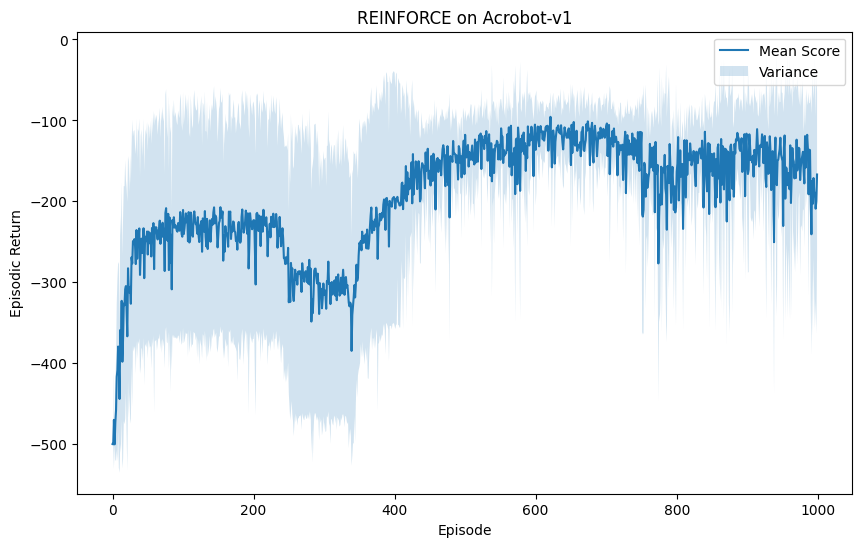

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_scores)), mean_scores, label='Mean Score')
plt.fill_between(range(len(mean_scores)), mean_scores - std_scores, mean_scores + std_scores, alpha=0.2, label='Variance')
plt.xlabel('Episode')
plt.ylabel('Episodic Return')
plt.title('REINFORCE on Acrobot-v1')
plt.legend()
plt.show()